In [1]:
import pandas as pd
import tensorflow as tf
import sys
print(sys.version)
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy
from ipywidgets import interact, widgets
from scipy import stats
import seaborn as sns
import os
import json
from pprint import pprint
import cv2

3.6.5 (default, Jun 17 2018, 12:13:06) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]


Using TensorFlow backend.


In [90]:
numGrids = 12
features = []
y = []
count = 0
for file in os.listdir("./imageLabel/."):
    if(file.startswith("A")):
        #file = "A (101)"
        print("Extracting labels from file " + file)
        data = json.loads(open('./imageLabel/' + file + "/data_file.json").read())
        img = cv2.imread("../../imagesDataset/" + file + ".jpg")
        if 'labels' in data:
            height, width, channels = img.shape
            gheight, gwidth = int(height/numGrids) , int(width/numGrids)
            for index, gridLabel in enumerate(data['labels']):
                if gridLabel:
                    colIndex = index % numGrids
                    rowIndex = int(index / numGrids)
                    grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth, :]
                    blur = cv2.resize(img, (256, 256))
                    
                    #feature extraction
                    featureList = []
                    gridRed = grid[:,:,0]
                    gridGreen = grid[:,:,1]
                    gridBlue = grid[:,:,2]
                    rbar = np.average(gridRed)
                    gbar = np.average(gridGreen)
                    bbar = np.average(gridBlue)
                    featureList.append(rbar)
                    featureList.append(gbar)
                    featureList.append(bbar)
                    featureList += np.bincount(np.ravel((gridRed/32).astype(int)), minlength = 8).tolist()
                    featureList += np.bincount(np.ravel((gridGreen/32).astype(int)), minlength = 8).tolist()
                    featureList += np.bincount(np.ravel((gridBlue/32).astype(int)), minlength = 8).tolist()
                    width, height, dimension = grid.shape
                    f = np.fft.fft2(grid)
                    fshift = np.fft.fftshift(f)
                    magnitude_spectrum = np.abs(20*np.log(np.abs(fshift + 0.00001)))
                    featureList += np.average(np.average(magnitude_spectrum,axis = 0), axis = 0).tolist()
                    featureList += [index]
                    features.append(featureList)
                    y.append(gridLabel)
#     count += 1
#     if(count == 1):
#         break
                    
features = np.asarray(features)
#features = features / features.max(axis=0)
print("Features shape", features.shape, " label shape", len(y))  

Extracting labels from file A (108)
Extracting labels from file A (141)
Extracting labels from file A (243)
Extracting labels from file A (187)
Extracting labels from file A (225)
Extracting labels from file A (30)
Extracting labels from file A (127)
Extracting labels from file A (164)
Extracting labels from file A (15)
Extracting labels from file A (249)
Extracting labels from file A (200)
Extracting labels from file A (102)
Extracting labels from file A (209)
Extracting labels from file A (240)
Extracting labels from file A (184)
Extracting labels from file A (142)
Extracting labels from file A (124)
Extracting labels from file A (9)
Extracting labels from file A (226)
Extracting labels from file A (33)
Extracting labels from file A (39)
Extracting labels from file A (3)
Extracting labels from file A (167)
Extracting labels from file A (148)
Extracting labels from file A (101)
Extracting labels from file A (16)
Extracting labels from file A (203)
Extracting labels from file A (237)
E

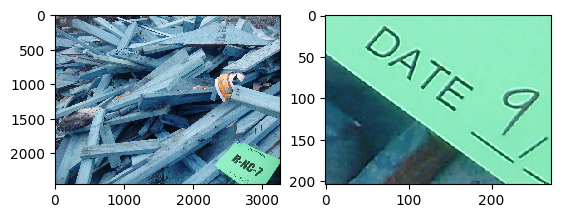

In [97]:
def drawGrid(picNum, index):
    img = cv2.imread("../../imagesDataset/" + "A ("+ str(picNum) +")" + ".jpg")
    colIndex = index % numGrids
    rowIndex = int(index / numGrids)
    grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth]
    plt.subplot(121),plt.imshow(img)
    plt.subplot(122),plt.imshow(grid)
    
drawGrid(101, 141)

In [98]:
features[:,30].shape

(10167,)

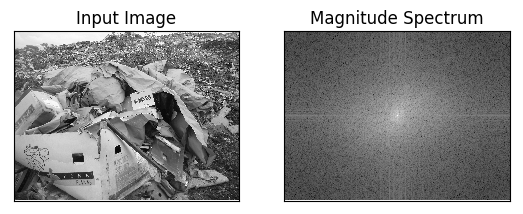

10167

In [99]:
img = cv2.imread("../../imagesDataset/" + "A (254)" + ".jpg", 0)
grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth]
rowIndex = index % numGrids
colIndex = int(index / numGrids)
width, height = grid.shape
f = np.fft.fft2(grid)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.abs(20*np.log(np.abs(fshift)))


plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()
len(y)

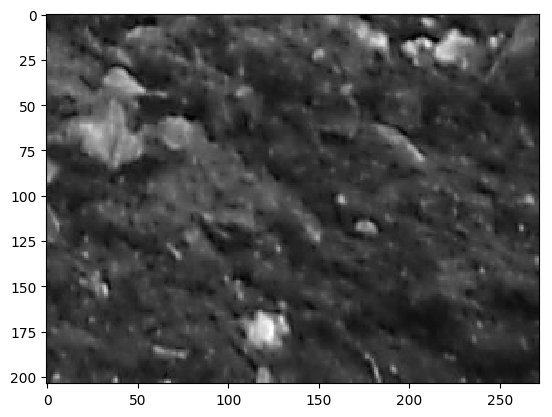

In [100]:
plt.imshow(grid, cmap = 'gray')


In [101]:
width, height = grid.shape
f = np.fft.fft2(grid/256.)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.abs(20*np.log(np.abs(fshift)))
np.average(np.average(magnitude_spectrum,axis = 0), axis = 0)


22.59481968902599

In [102]:
#normalize all data
features = features / features.max(axis=0)

In [103]:
jobs = list(set(y))
counts = [y.count(job) for job in jobs]
print(jobs)
print(counts)

['Roofing', 'Organics', 'Concrete', 'Bricks', 'Other', 'Wood', 'Plastic', 'Gypsum', 'Metal']
[1833, 45, 420, 22, 570, 5431, 1111, 268, 467]


Text(0.5, 1.0, 'Number of Labels for Each Waste Type')

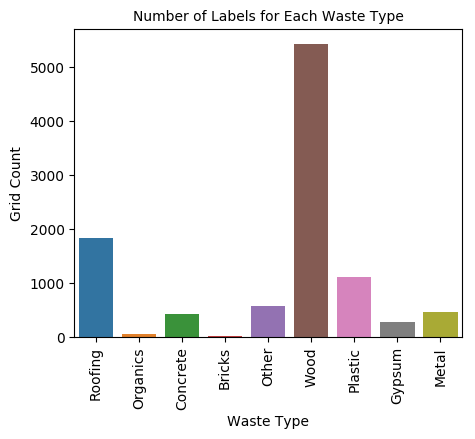

In [104]:
f, ax = plt.subplots(figsize=(5, 4))
plt.xticks(rotation='90')
sns.barplot(x=jobs, y=counts)
plt.xlabel('Waste Type', fontsize=10)
plt.ylabel('Grid Count', fontsize=10)
plt.title('Number of Labels for Each Waste Type', fontsize=10)

In [105]:
stringDic = {}
for i in range(len(jobs)):
    stringDic[jobs[i]] = i

if isinstance(y, list):
    for i in range (len(y)):
        if(y[i] in stringDic):
            y[i] = stringDic[y[i]]
print("Features shape", features.shape, " label shape", len(y))

Features shape (10167, 31)  label shape 10167


In [106]:
reverseDic = {v: k for k, v in stringDic.items()}

import pickle

pickle_out = open("dict.pickle","wb")
pickle.dump(reverseDic, pickle_out)
pickle_out.close()

Feature Extracting Themes
1. Input Vector: RGB-bar (3)
2. RGB-frequencies into 8 factors histograms (8 * 3)
3. 256 gradient map (8 * 3)
4. Hue, Saturation, Lightness

average 0.15102934588903974 variance 0.029433176339350765


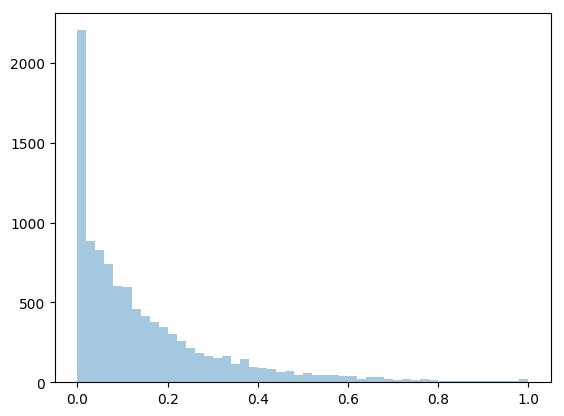

In [107]:
import seaborn as sns
colorIndex = 7
print("average", np.average(features[:,colorIndex]), "variance", np.var(features[:,colorIndex]))
sns.distplot(features[:,colorIndex],kde=False)

In [108]:
from sklearn.model_selection import train_test_split

# split dataset into 80% training data points and 20% testing data points

train_Y_one_hot = to_categorical(y)
train_X,test_X,train_label,test_label = train_test_split(features, train_Y_one_hot, test_size=0.2, random_state=12)

print('Training data shape : ', train_X.shape, train_label.shape, 'Testing data shape: ', test_X.shape, test_label.shape)

Training data shape :  (8133, 31) (8133, 9) Testing data shape:  (2034, 31) (2034, 9)


In [109]:
# identify the number of classes and 

classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', jobs)

Total number of outputs :  9
Output classes :  ['Roofing', 'Organics', 'Concrete', 'Bricks', 'Other', 'Wood', 'Plastic', 'Gypsum', 'Metal']


In [110]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_label, test_size=0.2, random_state=13)
print('Training data shape : ', train_X.shape, train_label.shape, 'Validing data shape: ', valid_X.shape, valid_label.shape)

Training data shape :  (6506, 31) (6506, 9) Validing data shape:  (1627, 31) (1627, 9)


In [111]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import normalize

In [112]:
batch_size = 64
epochs = 200
num_classes = nClasses

model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(features.shape[1],)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(nClasses, activation=tf.nn.softmax)
])

In [113]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                512       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 297       
Total params: 1,625
Trainable params: 1,625
Non-trainable params: 0
_________________________________________________________________


In [115]:
tf.contrib.training.HParams(learning_rate=0.1, num_hidden_units=100)

HParams([('learning_rate', 0.1), ('num_hidden_units', 100)])

In [116]:
result = model.fit(features, train_Y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 10167 samples, validate on 1627 samples
Epoch 1/200
10167/10167 [==============================] - 1s 55us/step - loss: 1.5780 - acc: 0.4905 - val_loss: 1.3504 - val_acc: 0.5612
Epoch 2/200
10167/10167 [==============================] - 0s 23us/step - loss: 1.3169 - acc: 0.5889 - val_loss: 1.2645 - val_acc: 0.6159
Epoch 3/200
10167/10167 [==============================] - 0s 24us/step - loss: 1.2221 - acc: 0.6254 - val_loss: 1.1667 - val_acc: 0.6411
Epoch 4/200
10167/10167 [==============================] - 0s 22us/step - loss: 1.1436 - acc: 0.6522 - val_loss: 1.1102 - val_acc: 0.6632
Epoch 5/200
10167/10167 [==============================] - 0s 25us/step - loss: 1.1057 - acc: 0.6603 - val_loss: 1.0915 - val_acc: 0.6577
Epoch 6/200
10167/10167 [==============================] - 0s 20us/step - loss: 1.0884 - acc: 0.6624 - val_loss: 1.0970 - val_acc: 0.6620
Epoch 7/200
10167/10167 [==============================] - 0s 20us/step - loss: 1.0719 - acc: 0.6696 - val_loss: 1.0737 - v

10167/10167 [==============================] - 0s 28us/step - loss: 0.9214 - acc: 0.7009 - val_loss: 0.9175 - val_acc: 0.7050
Epoch 60/200
10167/10167 [==============================] - 0s 27us/step - loss: 0.9199 - acc: 0.7007 - val_loss: 0.9168 - val_acc: 0.7037
Epoch 61/200
10167/10167 [==============================] - 0s 29us/step - loss: 0.9209 - acc: 0.7006 - val_loss: 0.9238 - val_acc: 0.6964
Epoch 62/200
10167/10167 [==============================] - 0s 28us/step - loss: 0.9157 - acc: 0.7039 - val_loss: 0.9136 - val_acc: 0.7081
Epoch 63/200
10167/10167 [==============================] - 0s 29us/step - loss: 0.9148 - acc: 0.7032 - val_loss: 0.9142 - val_acc: 0.7081
Epoch 64/200
10167/10167 [==============================] - 0s 27us/step - loss: 0.9128 - acc: 0.7046 - val_loss: 0.9169 - val_acc: 0.7099
Epoch 65/200
10167/10167 [==============================] - 0s 23us/step - loss: 0.9108 - acc: 0.7049 - val_loss: 0.9035 - val_acc: 0.7154
Epoch 66/200
10167/10167 [==============

Epoch 118/200
10167/10167 [==============================] - 0s 25us/step - loss: 0.8508 - acc: 0.7142 - val_loss: 0.8543 - val_acc: 0.7074
Epoch 119/200
10167/10167 [==============================] - 0s 23us/step - loss: 0.8486 - acc: 0.7154 - val_loss: 0.8304 - val_acc: 0.7259
Epoch 120/200
10167/10167 [==============================] - 0s 24us/step - loss: 0.8515 - acc: 0.7121 - val_loss: 0.8424 - val_acc: 0.7117
Epoch 121/200
10167/10167 [==============================] - 0s 22us/step - loss: 0.8497 - acc: 0.7129 - val_loss: 0.8340 - val_acc: 0.7167
Epoch 122/200
10167/10167 [==============================] - 0s 22us/step - loss: 0.8483 - acc: 0.7185 - val_loss: 0.8376 - val_acc: 0.7179
Epoch 123/200
10167/10167 [==============================] - 0s 22us/step - loss: 0.8468 - acc: 0.7154 - val_loss: 0.8364 - val_acc: 0.7240
Epoch 124/200
10167/10167 [==============================] - 0s 20us/step - loss: 0.8497 - acc: 0.7183 - val_loss: 0.8372 - val_acc: 0.7111
Epoch 125/200
10167/

10167/10167 [==============================] - 0s 23us/step - loss: 0.8169 - acc: 0.7187 - val_loss: 0.8091 - val_acc: 0.7228
Epoch 177/200
10167/10167 [==============================] - 0s 24us/step - loss: 0.8165 - acc: 0.7227 - val_loss: 0.8131 - val_acc: 0.7210
Epoch 178/200
10167/10167 [==============================] - 0s 24us/step - loss: 0.8173 - acc: 0.7211 - val_loss: 0.8108 - val_acc: 0.7222
Epoch 179/200
10167/10167 [==============================] - 0s 22us/step - loss: 0.8176 - acc: 0.7196 - val_loss: 0.8021 - val_acc: 0.7203
Epoch 180/200
10167/10167 [==============================] - 0s 22us/step - loss: 0.8169 - acc: 0.7208 - val_loss: 0.8071 - val_acc: 0.7210
Epoch 181/200
10167/10167 [==============================] - 0s 24us/step - loss: 0.8152 - acc: 0.7198 - val_loss: 0.8075 - val_acc: 0.7173
Epoch 182/200
10167/10167 [==============================] - 0s 25us/step - loss: 0.8185 - acc: 0.7191 - val_loss: 0.8046 - val_acc: 0.7228
Epoch 183/200
10167/10167 [=======

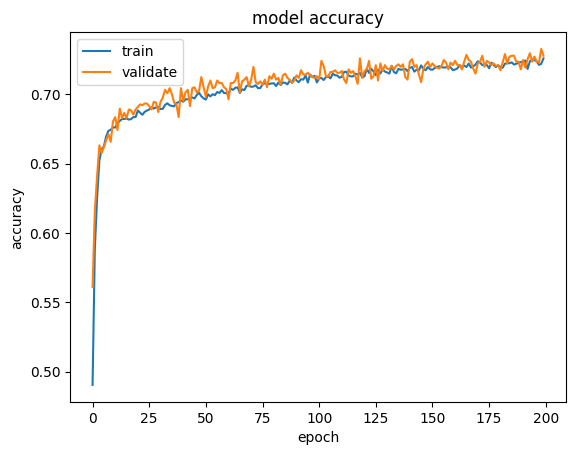

In [130]:
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig('img/train_validate_accuracy.png')
plt.show()

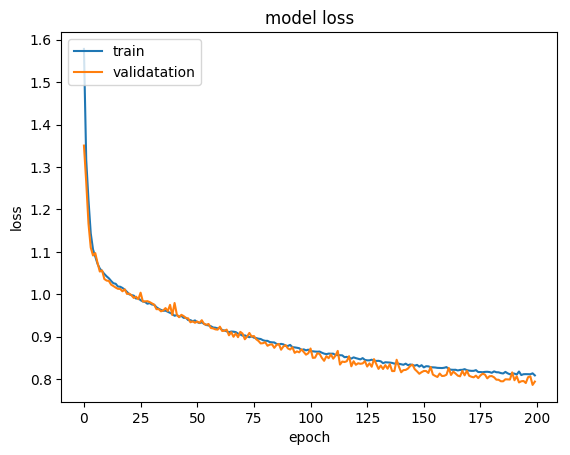

In [131]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validatation'], loc='upper left')
plt.savefig('img/train_validate_loss.png')
plt.show()

The training completes here. We save the model and load the model when test cases are invoked 

In [119]:
k = model.predict_classes(test_X)

In [120]:
print(list(set(k)))
print([list(k).count(job) for job in list(set(k))])

[0, 2, 4, 5, 6, 7, 8]
[449, 30, 32, 1307, 171, 13, 32]


In [121]:
print("The test set given by the neural network has an accuracy of ", sum(k == np.argmax(test_label, axis = 1))/len(k))

The test set given by the neural network has an accuracy of  0.7266470009832842


In [122]:
correct_test = np.argmax(test_label[(np.argmax(test_label, axis=1) == k)],axis=1)
incorrect_test = np.argmax(test_label[(np.argmax(test_label, axis=1) != k)],axis=1)

['Roofing', 'Organics', 'Concrete', 'Bricks', 'Other', 'Wood', 'Plastic', 'Gypsum', 'Metal']
[360, 9, 94, 9, 114, 1102, 214, 47, 85]
['Roofing', 'Concrete', 'Other', 'Wood', 'Plastic', 'Gypsum', 'Metal']
[449, 30, 32, 1307, 171, 13, 32]
['Roofing', 'Concrete', 'Other', 'Wood', 'Plastic', 'Gypsum', 'Metal']
[324, 14, 20, 999, 102, 10, 9]
['Roofing', 'Organics', 'Concrete', 'Bricks', 'Other', 'Wood', 'Plastic', 'Gypsum', 'Metal']
[36, 9, 80, 9, 94, 103, 112, 37, 76]


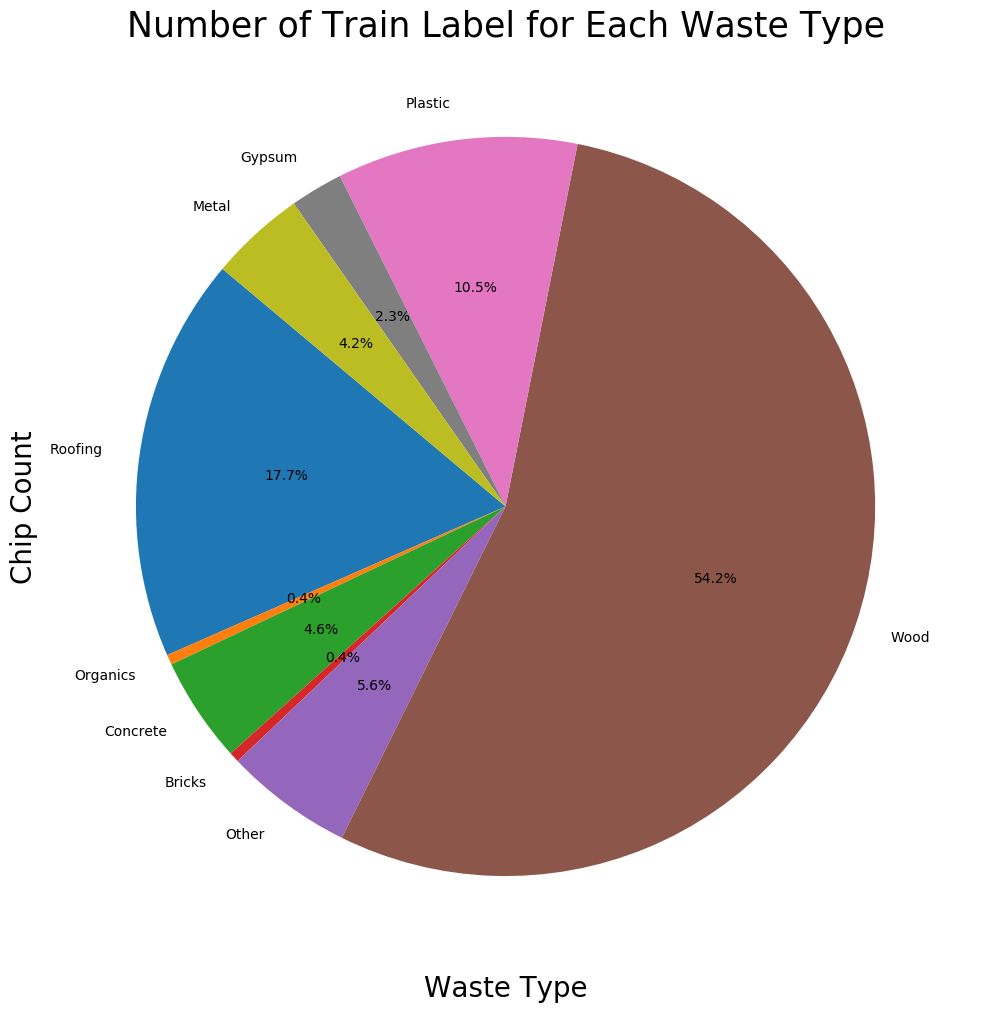

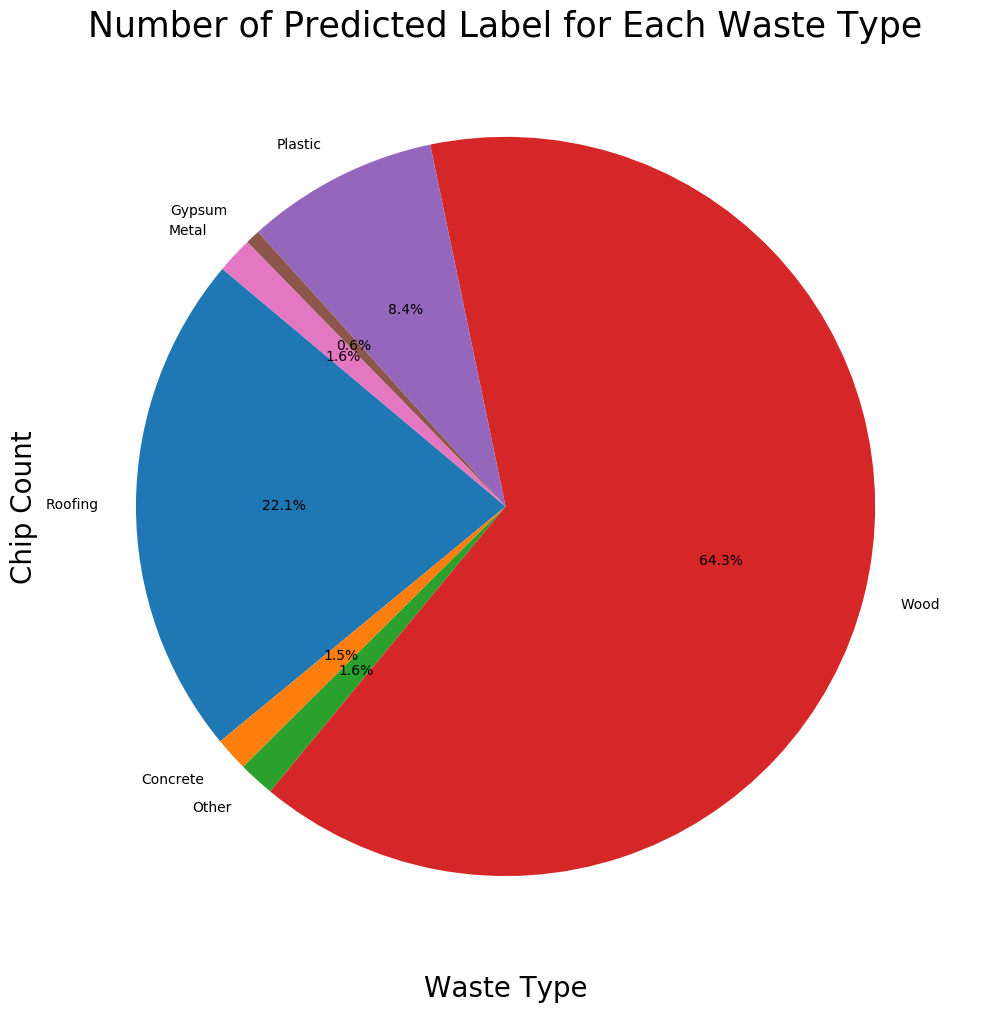

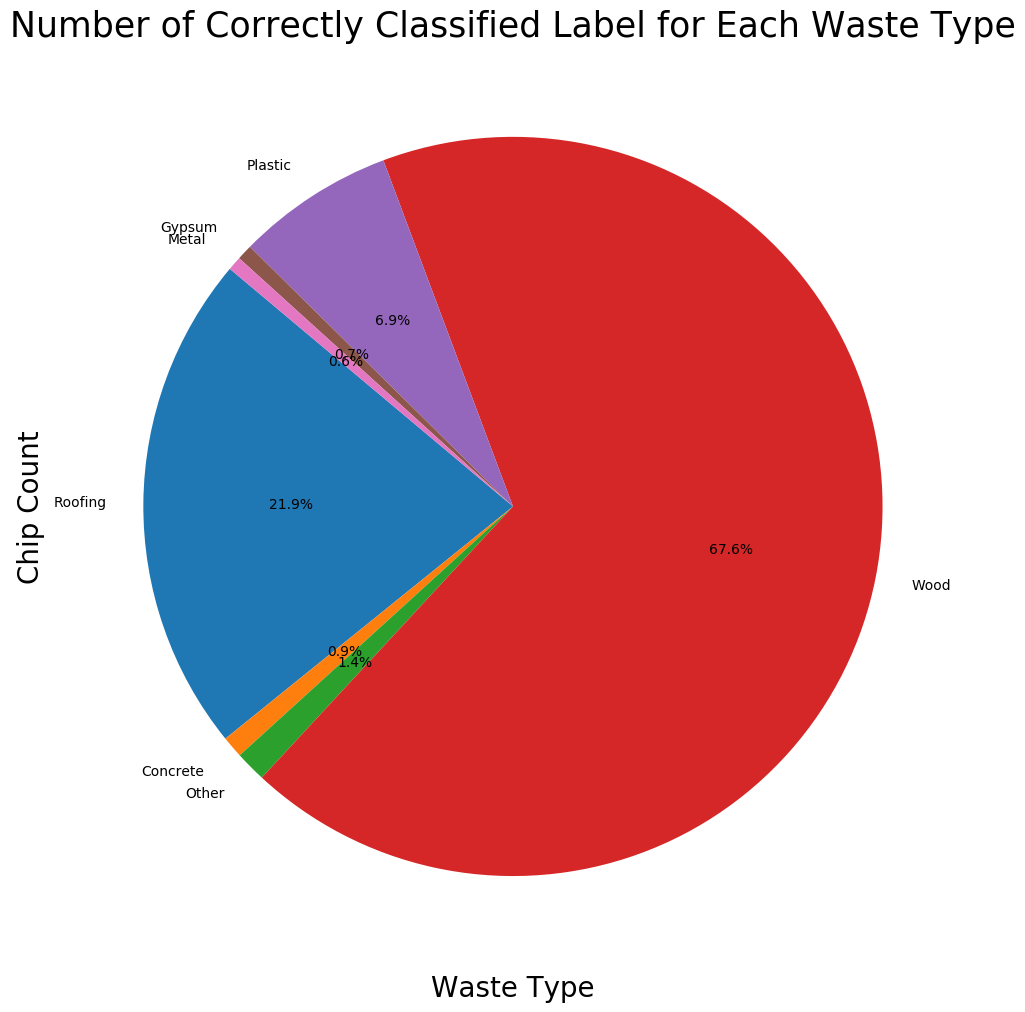

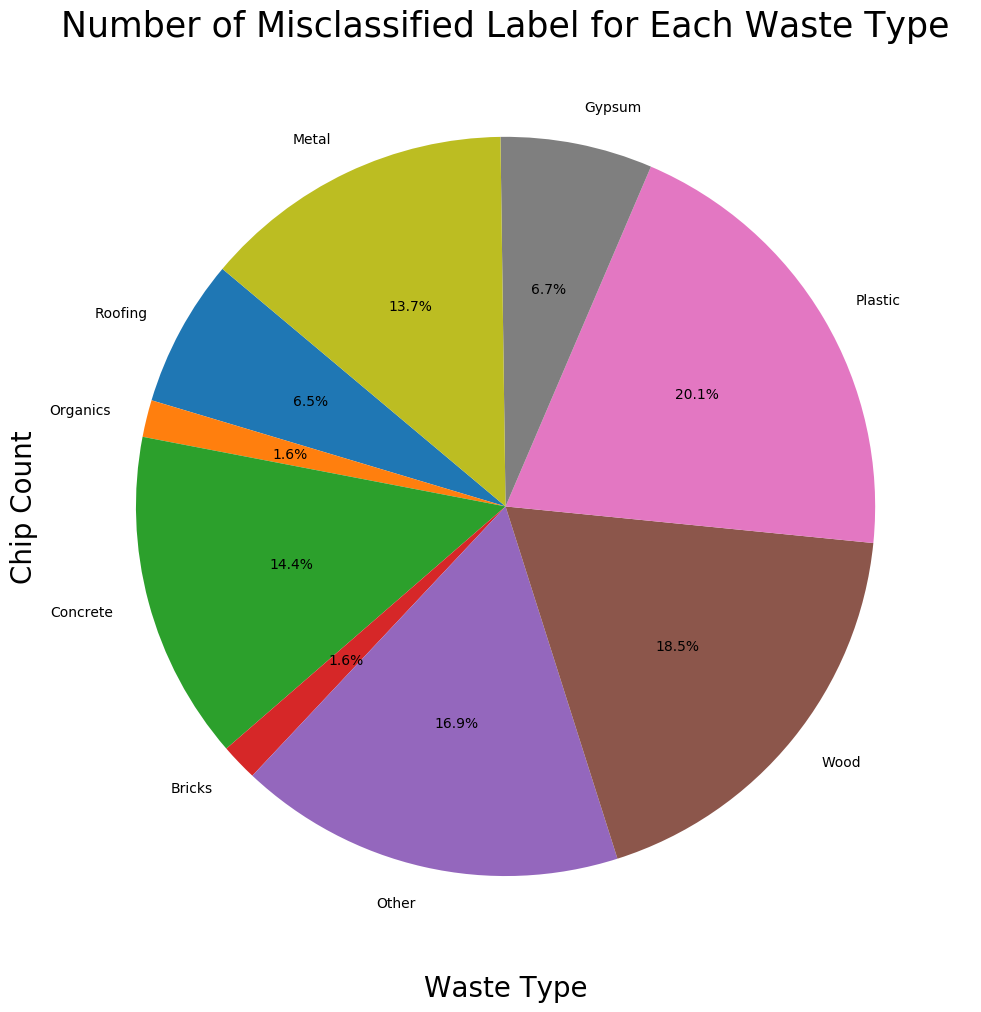

In [126]:
def drawHist(label, name):
    #test_label distribution
    test_material = [reverseDic[material] for material in list(set(label))]
    print(test_material)
    test_count = [list(label).count(job) for job in list(set(label))]
    print(test_count)
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    #sns.barplot(x=test_material, y=test_count)
    plt.pie(test_count, labels=test_material, autopct='%1.1f%%', startangle=140)
    plt.xlabel('Waste Type', fontsize=20)
    plt.ylabel('Chip Count', fontsize=20)
    plt.title('Number of ' + name + ' for Each Waste Type', fontsize=25)
    name = name.replace(" ", "_")
    f.savefig("img/" + str(name) + '.png')

drawHist(np.argmax(test_label, axis=1), "Train Label")
drawHist(k, "Predicted Label")
drawHist(correct_test, "Correctly Classified Label")
drawHist(incorrect_test, "Misclassified Label")

In [78]:
regularization = 0.0000001
weight = np.linalg.inv(train_X.T.dot(train_X)+regularization * np.eye(features.shape[1])).dot(train_X.T).dot(train_label)
print("The weight shape is ", weight.shape)
k = np.argmax(test_X.dot(weight), axis = 1)
print(list(set(k)))
print([list(k).count(job) for job in list(set(k))])
print("The test set gives an accuracy of ", sum(k == np.argmax(test_label, axis = 1))/len(k))

The weight shape is  (31, 9)
[0, 5, 6, 7, 8]
[445, 1470, 113, 1, 5]
The test set gives an accuracy of  0.6745329400196657


In [79]:
np.linalg.norm(weight)

241.6173860003934

In [80]:
import seaborn as sns
featuresPd = pd.DataFrame(features)
featuresPd.columns = ["Red-bar","Green-bar","Blue-bar",
                      "Red lvl 1","Red lvl 2","Red lvl 3","Red lvl 4","Red lvl 5","Red lvl 6","Red lvl 7","Red lvl 8",
"Green lvl 1","Green lvl 2","Green lvl 3","Green lvl 4","Green lvl 5","Green lvl 6","Green lvl 7","Green lvl 8",
"Blue lvl 1","Blue lvl 2","Blue lvl 3","Blue lvl 4","Blue lvl 5","Blue lvl 6","Blue lvl 7","Blue lvl 8",
                     "Red FFT", "Green FFT", "Blue FFT", "index"]
featuresPd['label'] = pd.Series(np.array(y).reshape(-1,), index=featuresPd.index)
corrMat = featuresPd.corr()

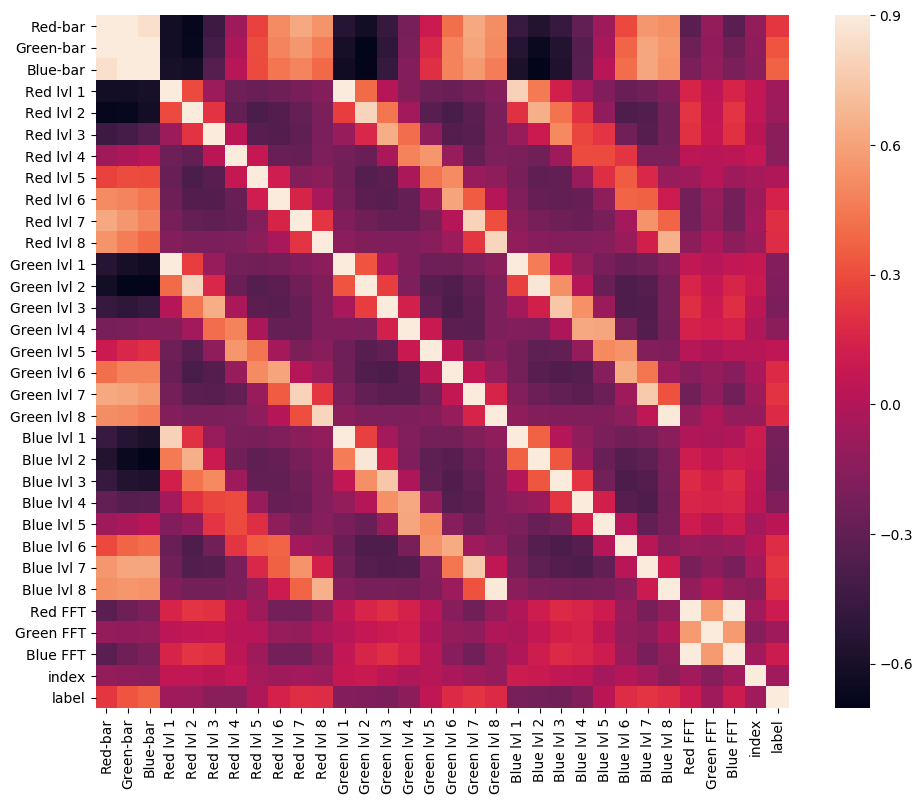

In [133]:
plt.subplots(figsize=(12,9))
corrMat = featuresPd.corr()
sns.heatmap(corrMat, vmax=0.9, square=True)
plt.savefig("img/corrMat.png")

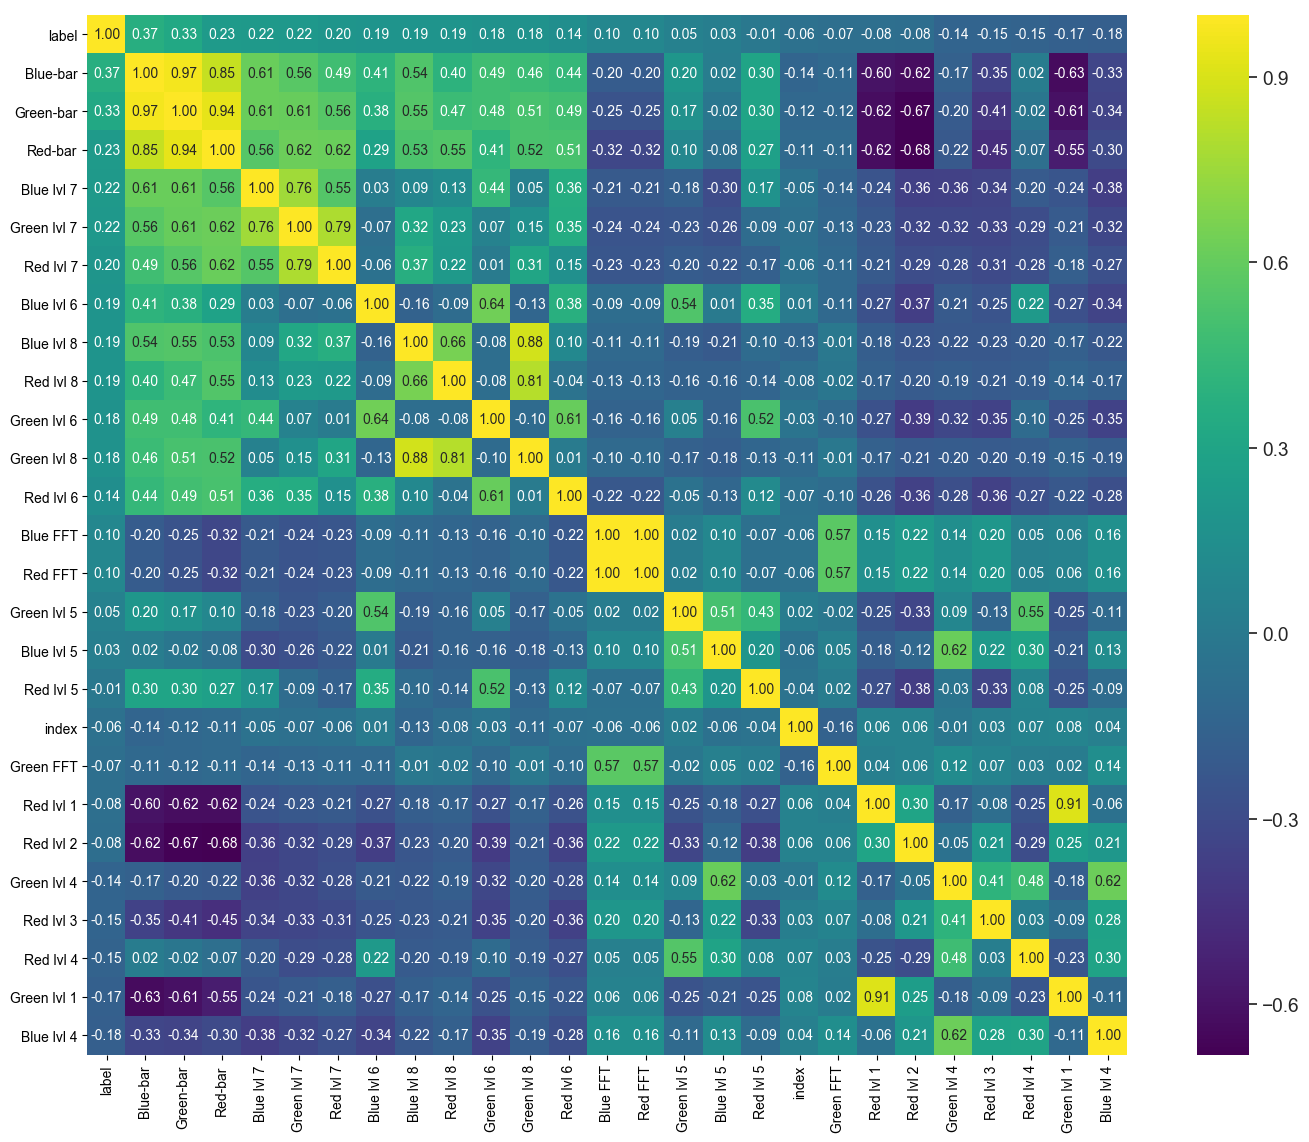

In [134]:
k = 27 #number of variables for heatmap
plt.subplots(figsize=(18,13.5))
cols = corrMat.nlargest(k, 'label')['label'].index
cm = np.corrcoef(featuresPd[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap= 'viridis',cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.savefig("img/featureMap.png")
plt.show()

In [124]:
model.save("model.h5py")